[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)]()

In [20]:
from __future__ import division
import time
import os
import copy
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from attack import * 

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
#Download dataset :  !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [193]:
data_dir = "./data"
model_name = "vgg"
# Number of classes in the dataset
num_classes = 2
name_classes = {1 : 'Bees', 
                0:'Ants'}

In [194]:
# Importing models 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model : VGG11 
model_ft = models.vgg11_bn(pretrained=True).to(device)

## Don't compute grad of params
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.classifier[6].in_features
# Force out features to two classes : we have ants and bees
model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
input_size = 224

In [195]:
# import data
data_transforms = {
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in [ 'val']}

testloader = torch.utils.data.DataLoader(image_datasets['val'], 
                                         batch_size=1, 
                                         shuffle=True, 
                                         num_workers=4)

In [196]:
# Get one exemple 
for d, t in testloader :
    data , target = d ,t 
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


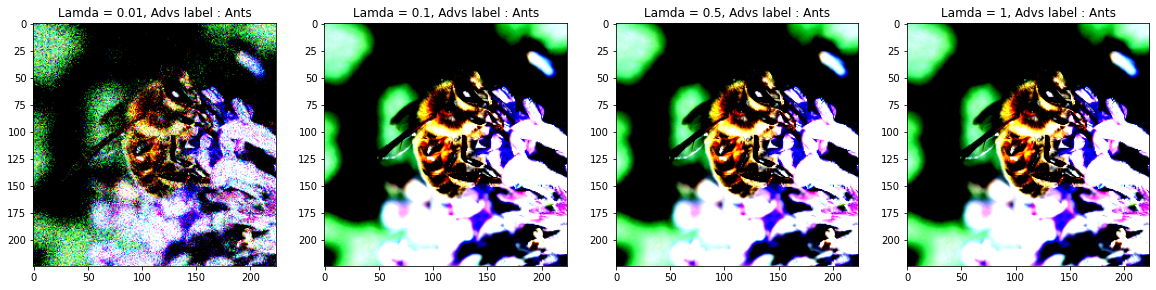

In [197]:
lmds =[0.01,0.1, 0.5,1]
fig, ax = plt.subplots(1,len(lmds),figsize=(20,10))

for i, lmd in enumerate(lmds) : 
    adv = target_adversarial(model_ft,d,device,n=0,lmd=lmd)
    label = model_ft(adv).max(1, keepdim=True)[1]
    adv = adv.squeeze().detach().cpu().permute(1, 2, 0)
    ax[i].imshow(adv)
    ax[i].set_title("Lamda = {}, Advs label : {}".format(lmd,name_classes[label.item()]))

Not a robust method : 
> The method can sometimes be defeated merely by degrading the image quality, for example, by rounding to an 8-bit representation of each pixel.

### Testing FGSM 

In [24]:
accuracies = []
examples = []
epsilons =[0.1,0.3,0.5,0.7]

#Run test for each epsilon
for i , eps in enumerate(epsilons):
    adv_examples, final_acc  = generate_adv(model_ft,testloader,epsilon=eps)
    accuracies.append(final_acc)
    examples.append(adv_examples)    

100%|██████████| 153/153 [00:51<00:00,  2.99it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


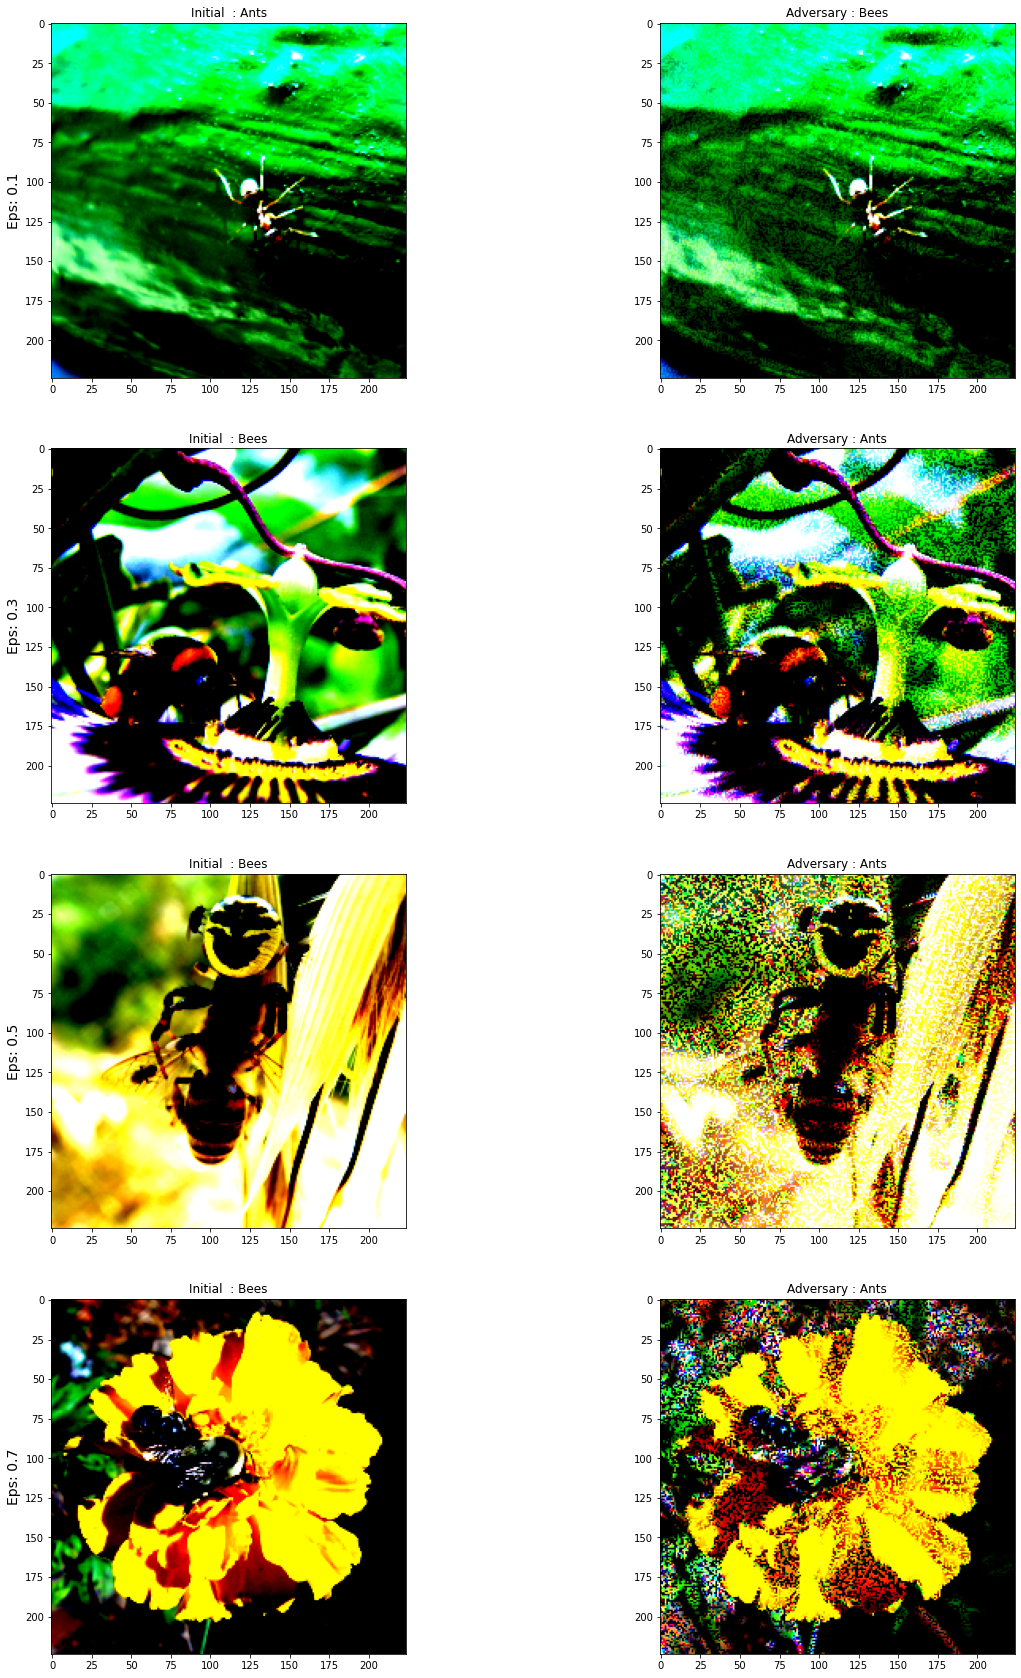

In [25]:
fig , axs = plt.subplots(nrows=len(epsilons), ncols=2,figsize=(20,30))

for i , eps in enumerate(epsilons):
    original, adversary, init_pred , final_pred = examples[i][0]
    axs[i, 0].imshow(original)
    axs[i,0].set_ylabel("Eps: {}".format(eps), fontsize=14)
    axs[i, 0].set_title('Initial  : {}'.format(name_classes[init_pred.item()]))
    axs[i, 1].imshow(adversary)
    axs[i, 1].set_title('Adversary : {}'.format(name_classes[final_pred.item()]))

In [306]:
acc = validation(model_ft, testloader,device)

100%|██████████| 153/153 [00:27<00:00,  5.64it/s]


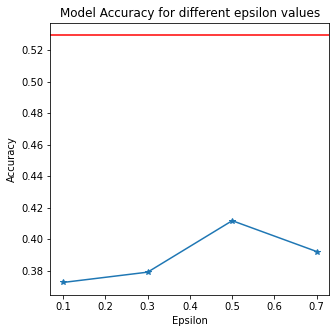

In [321]:
import seaborn as sns 
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(epsilons, accuracies, "*-")
plt.axhline(y=acc,color='r')
plt.title("Model Accuracy for different epsilon values")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Testing Adversaries on different model

In [140]:
#!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

In [110]:
## Model : VGG11 
model_res = models.resnet18(pretrained=True).to(device)

model_res.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [132]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class :  bee


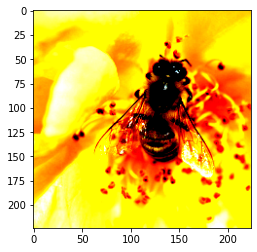

In [139]:
for d , t in testloader :
    data =d.to(device)
    target = t
    break

print('Class : ',classes[torch.argmax(model_res(data)).item()])
plt.imshow(data.squeeze().detach().cpu().permute(1, 2, 0))

In [143]:
# Make inference on the data
output=model_res(data)
probabilities = nn.functional.softmax(output[0], dim=0)

In [144]:
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

bee 0.984476625919342
fly 0.010830802842974663
ant 0.0007648112950846553
leafhopper 0.0005006956052966416
honeycomb 0.00040298147359862924


In [162]:
# Generate adversarial exemples with L-BFGS
adv_examples, final_acc  = generate_adv(model_ft,[(data,t)],epsilon=0.5)

original, adversary, init_pred , final_pred = adv_examples[0]
adversary = adversary.reshape(data.size())

# Make inference on the data
output=model_res(adversary)
probabilities = nn.functional.softmax(output[0], dim=0)

# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

window screen 0.10468530654907227
wall clock 0.030803218483924866
lampshade 0.020914221182465553
fire screen 0.020613592118024826
lacewing 0.020526012405753136


In [198]:
# Generate adversarial exemples with L-BFGS
adv_examples  = target_adversarial(model_ft,data,device,n=1,lmd=0.01)
adv = adv_examples.squeeze().detach().cpu().permute(1, 2, 0)

In [199]:
# Make inference on the data using Resnet
output=model_res(adv_examples)
probabilities = nn.functional.softmax(output[0], dim=0)

# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

wolf spider 0.4596182107925415
tarantula 0.28747063875198364
bee 0.07385461777448654
crayfish 0.03633728250861168
barn spider 0.02058088779449463
